In [1]:
cd ..


/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS


## Imports

In [3]:
%load_ext autoreload
from pennylane import numpy as pnp
from tqdm import tqdm
from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import pennylane as qml
import jax.numpy as jnp
import optax
import jax
import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial Weights: Either Randomly Assigned With No Restrictions or Weights Near Unitary

In [4]:
weights_random = jnp.array(pnp.random.normal(size=(88, 15), requires_grad=True))

weights_near_unitary = jnp.array(pnp.random.uniform(low = -0.01, high=0.01, size=(88, 15), requires_grad=True))

## Circuit

(<Figure size 8200x1300 with 1 Axes>, <Axes: >)

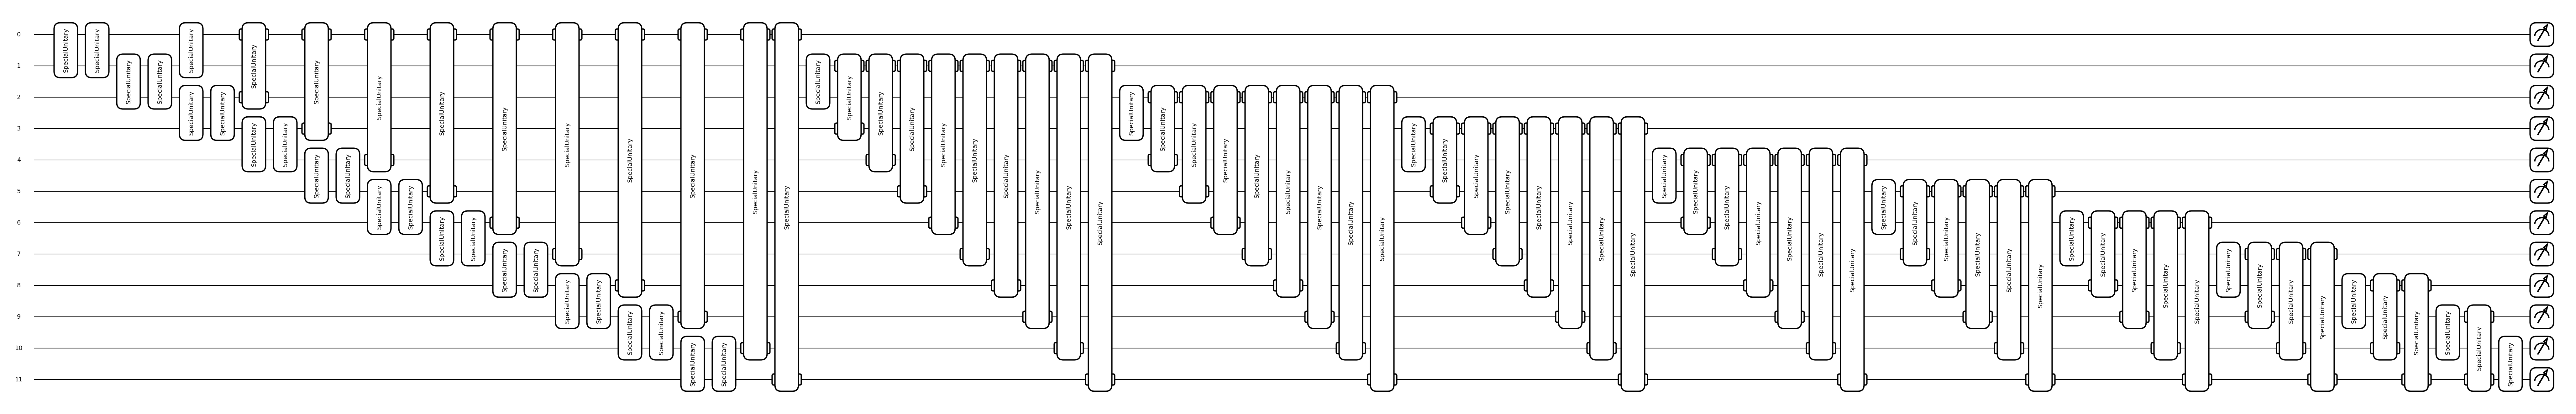

In [11]:
def random_initialized_circuit(weights, shots = None, wires = 12):
    dev = qml.device("default.qubit", wires=wires, shots=shots)
    
    @qml.qnode(dev, interface="jax")
    def qnode():
        for i in range(11):
            qml.SpecialUnitary(weights[i], wires=[i, i + 1])
            qml.SpecialUnitary(weights[i + 11], wires=[i, i  + 1])
        
        for x in range(wires - 1):
            for j in range(x + 1, wires):
                qml.SpecialUnitary(weights[i], wires=[x, j])
                i += 1

        if shots is not None:
            return qml.sample()
        
        return qml.probs(wires=list(range(wires)))
    
    return qnode

qml.drawer.draw_mpl(random_initialized_circuit(weights_random))()


## Training of the Model

In [14]:
N_ITS = 10000
LEARNING_RATE = 0.01

opt_exc = optax.adam(LEARNING_RATE)
opt_state = opt_exc.init(weights_random)
loss_track = []

@jax.jit
def loss(weights):
    probs = random_initialized_circuit(weights)()
    return metrics.kl_divergence_synergy_paper(2 ** 12, probs)


for it in tqdm(range(N_ITS)):
    grads = jax.grad(loss)(weights_random)
    updates, opt_state = opt_exc.update(grads, opt_state)
    weights_random = optax.apply_updates(weights_random, updates)
    loss_track.append(loss(weights_random))

100%|██████████| 10000/10000 [30:21<00:00,  5.49it/s] 


## Plot KL - Divergence

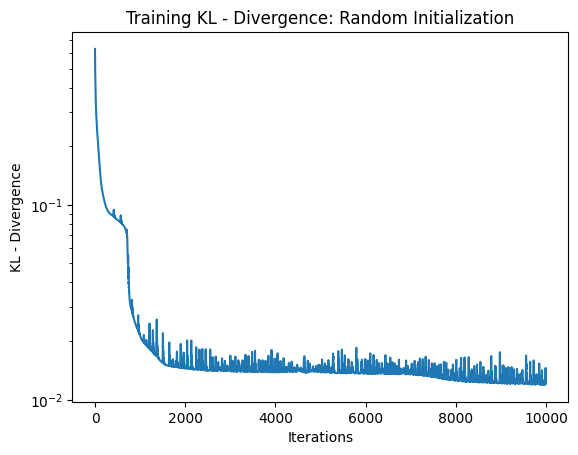

In [18]:
plt.plot(loss_track)
plt.title('Training KL - Divergence: Random Initialization')
plt.xlabel('Iterations')
plt.ylabel('KL - Divergence')
plt.yscale('log')

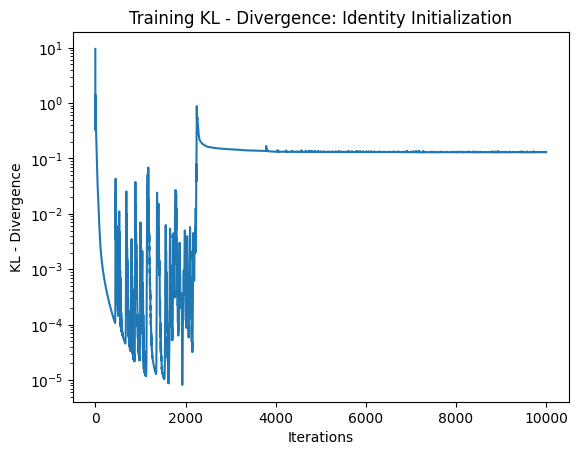

In [15]:
plt.plot(loss_track)
plt.title('Training KL - Divergence: Identity Initialization')
plt.xlabel('Iterations')
plt.ylabel('KL - Divergence')
plt.yscale('log')

18
